In [7]:
# enable auto reload of modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# This part ensures that we can later import loca         return  torch.tensor(0.) l functions 
# from a module in another directory with relative imports

import os
from os import listdir
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
from glob import glob
import logging
import matplotlib.pyplot as plt
import argparse
import socket
import time
from datetime import datetime
from tqdm import tqdm
import numpy as np
from scipy import sparse, ndimage
import torch
import torch.nn as nn        #Dice coeff

from torch import optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

import pandas as pd
import matplotlib.pyplot as plt

# from src.models.unet import UNet
from src.data.maya_dataset import MayaDataset, MayaTransform, split_data
from src.visualization.visualize import visualize_output_of_dataloader
from src.models.eval_model import eval_net
from src.models.deeplabv3 import DeepLabV3
from src.models.unet import UNet
from src.models.unet_adv import UNet as UNetA
from src.models.eval_model import eval_net
from src.models.losses import maya_dice_coeff, maya_iou

from collections import defaultdict

In [10]:
# Data loaders
dir_img_root = '../data/processed/'

batch_size=8

train_dataset = MayaDataset(dir_img_root, split="train", transform = MayaTransform(use_augmentations=True, use_advanced_augmentations=True))
#NOTE: The val dataset is same as train except it has no augmentations applied!!
val_dataset = MayaDataset(dir_img_root, split="train", transform = MayaTransform(use_augmentations=False))

train_loader, val_loader = split_data(
        None, train_dataset, val_dataset,
        100, 1, 1, 0, oversampling=False
    )


In [11]:
# If you don't have this model locally, you can sync it via `make sync_models_from_s3`

model_path = "../runs/unet_adv_bce_6e-05_cs-256_nga-2_bs-52_no-oversampling_sampling-pixelshuffle_nup-spectral_arch-swin-b_Jun28_00-26-44_0_b4ac813ab321/model/BestModel.pth"
model_type = "unet_adv"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if model_type == "unet":
    net = UNet.load_model(model_path, device)
elif model_type == "deeplabv3":
    net = DeepLabV3.load_model(model_path, device)
elif model_type == "unet_adv":
    net = UNetA.load_model(model_path, device)
else:
    raise Exception(f'Unknowng model type: {model_type}')




In [12]:
net.eval()
loss_criterion = nn.BCEWithLogitsLoss(reduction="mean")
n = len(val_loader)
out_threshold = 0.0
iou_absent=1.0

In [13]:
df = pd.DataFrame(columns=["tile", "building_gt_mean", "building_pred_mean", "platform_gt_mean", "platform_pred_mean", "aguada_gt_mean", "aguada_pred_mean", "loss_building", "loss_platform", "loss_aguada", "iou_building", "iou_platform", "iou_aguada" ])

with tqdm(total=n, desc='Inference', unit='batch', leave=False) as pbar:
    for batch in val_loader:
        lidar = batch['lidar'].to(device=device, dtype=torch.float32)
        sentinel2 = batch['sentinel2'].to(device=device, dtype=torch.float32)
        mask_building = batch['mask_building'].to(device=device, dtype=torch.float32)
        mask_platform = batch['mask_platform'].to(device=device, dtype=torch.float32)
        mask_aguada = batch['mask_aguada'].to(device=device, dtype=torch.float32)

        with torch.no_grad():
            masks_pred = net(lidar, sentinel2)

        loss = {
                'building' : loss_criterion(masks_pred[:, [0]], mask_building).item(),
                'platform' : loss_criterion(masks_pred[:, [1]], mask_platform).item(),
                'aguada' : loss_criterion(masks_pred[:, [2]], mask_aguada).item(),
                } 

        iou = maya_iou(masks_pred, mask_building, mask_platform, mask_aguada, absent_score=iou_absent)

        masks = masks_pred > out_threshold 

        _, number_of_buildings_gt = ndimage.label(mask_building.cpu().numpy().astype(np.uint8))
        _, number_of_platforms_gt = ndimage.label(mask_platform.cpu().numpy().astype(np.uint8))
        _, number_of_aguadas_gt = ndimage.label(mask_aguada.cpu().numpy().astype(np.uint8))
        _, number_of_buildings_pred = ndimage.label(masks[0, [0]].cpu().numpy().astype(np.uint8))
        _, number_of_platforms_pred = ndimage.label(masks[0, [1]].cpu().numpy().astype(np.uint8))
        _, number_of_aguadas_pred = ndimage.label(masks[0, [2]].cpu().numpy().astype(np.uint8))


        
        df = df.append({"tile": str(batch["idx"][0].item()),
                        "building_gt_mean": mask_building.cpu().numpy().astype(np.uint8).mean(),
                        "building_pred_mean": masks[0, [0]].cpu().numpy().astype(np.uint8).mean(), 
                        "platform_gt_mean": mask_platform.cpu().numpy().astype(np.uint8).mean(),
                        "platform_pred_mean":masks[0, [1]].cpu().numpy().astype(np.uint8).mean(), 
                        "aguada_gt_mean": mask_aguada.cpu().numpy().astype(np.uint8).mean(),
                        "aguada_pred_mean": masks[0, [2]].cpu().numpy().astype(np.uint8).mean(),
                        "loss_building": loss['building'], 
                        "loss_platform": loss['platform'], 
                        "loss_aguada": loss['aguada'],
                        "iou_building": iou['building'], 
                        "iou_platform": iou['platform'], 
                        "iou_aguada": iou['aguada'],
                        "number_of_buildings_gt": number_of_buildings_gt,
                        "number_of_platforms_gt": number_of_platforms_gt,
                        "number_of_aguadas_gt": number_of_aguadas_gt,
                        "number_of_buildings_pred": number_of_buildings_pred,
                        "number_of_platforms_pred": number_of_platforms_pred,
                        "number_of_aguadas_pred": number_of_aguadas_pred,},
                        ignore_index=True)


        pbar.update()

In [14]:
df.head(10)

,tile,building_gt_mean,building_pred_mean,platform_gt_mean,platform_pred_mean,aguada_gt_mean,aguada_pred_mean,loss_building,loss_platform,loss_aguada,iou_building,iou_platform,iou_aguada,number_of_aguadas_gt,number_of_aguadas_pred,number_of_buildings_gt,number_of_buildings_pred,number_of_platforms_gt,number_of_platforms_pred
0,0,0.000000,0.004718,0.000000,0.006979,0.0,0.0,0.006489,0.025591,0.000004,0.000000,0.000000,1.0,0.0,0.0,0.0,2.0,0.0,1.0
1,1000,0.006363,0.003976,0.033989,0.034661,0.0,0.0,0.006618,0.009954,0.000041,0.624829,0.884322,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,1001,0.000000,0.000994,0.001580,0.000000,0.0,0.0,0.001251,0.003096,0.000002,0.000000,0.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1002,0.013772,0.009661,0.001319,0.000000,0.0,0.0,0.019596,0.008218,0.000003,0.645535,0.000000,1.0,0.0,0.0,10.0,4.0,1.0,0.0
4,1003,0.006085,0.004991,0.000000,0.000000,0.0,0.0,0.003111,0.000117,0.000003,0.817664,1.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0
5,1004,0.013281,0.012274,0.008824,0.009362,0.0,0.0,0.012464,0.002260,0.000011,0.689042,0.915866,1.0,0.0,0.0,9.0,5.0,1.0,1.0
6,1005,0.004479,0.004792,0.000000,0.000000,0.0,0.0,0.003023,0.000010,0.000003,0.733766,1.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0
7,1006,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000013,0.000004,0.000003,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1007,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000031,0.000161,0.000006,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1008,0.000000,0.000000,0.000000,0.006736,0.0,0.0,0.000017,0.011144,0.000034,1.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,2.0


In [15]:
print(df["building_gt_mean"].corr(df['building_pred_mean']))
print(df["platform_gt_mean"].corr(df['platform_pred_mean']))
print(df["aguada_gt_mean"].corr(df['aguada_pred_mean']))

0.9934852958873649
0.9899231333058968
0.9972656999986635


<AxesSubplot:ylabel='Frequency'>

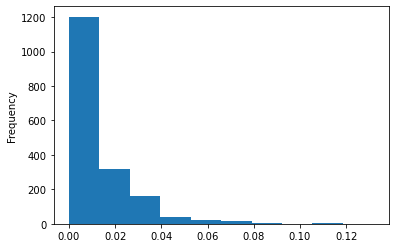

In [16]:
df['loss_building'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

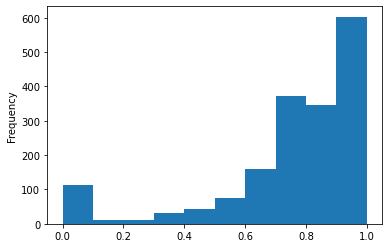

In [17]:
df['iou_building'].plot.hist()

In [18]:
quant_l = 0.975
q_l_building = df['loss_building'].quantile(quant_l)
q_l_platform = df['loss_platform'].quantile(quant_l)
q_l_aguada = df['loss_aguada'].quantile(quant_l)
quant_i = 0.075
q_i_building = df['iou_building'].quantile(quant_i)
q_i_platform = df['iou_platform'].quantile(quant_i)
q_i_aguada = df['iou_aguada'].quantile(quant_i)


# Only Loss
#df_select = df[(df['loss_building'] > q_l_building) | (df['loss_platform'] > q_l_platform)]
# Only IOU
#df_select = df[(df['iou_building'] < q_i_building) | (df['iou_platform'] < q_i_platform)] 
# Both
df_select = df[(df['loss_building'] > q_l_building) | (df['iou_building'] < q_i_building) | (df['loss_platform'] > q_l_platform) | (df['iou_platform'] < q_i_platform)] # | (df['loss_aguada'] > q_l_aguada) | (df['iou_aguada'] < q_i_aguada)

tiles = df_select['tile'][10:20]





In [19]:
df_select

,tile,building_gt_mean,building_pred_mean,platform_gt_mean,platform_pred_mean,aguada_gt_mean,aguada_pred_mean,loss_building,loss_platform,loss_aguada,iou_building,iou_platform,iou_aguada,number_of_aguadas_gt,number_of_aguadas_pred,number_of_buildings_gt,number_of_buildings_pred,number_of_platforms_gt,number_of_platforms_pred
0,0,0.000000,0.004718,0.000000,0.006979,0.0,0.0,0.006489,0.025591,0.000004,0.000000,0.000000,1.0,0.0,0.0,0.0,2.0,0.0,1.0
2,1001,0.000000,0.000994,0.001580,0.000000,0.0,0.0,0.001251,0.003096,0.000002,0.000000,0.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0
20,1018,0.042205,0.038880,0.083676,0.083394,0.0,0.0,0.059012,0.012444,0.000047,0.608160,0.941248,1.0,0.0,0.0,11.0,12.0,2.0,2.0
46,1041,0.000629,0.000000,0.000000,0.000052,0.0,0.0,0.002349,0.000568,0.000010,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0
47,1042,0.006050,0.000035,0.007357,0.004740,0.0,0.0,0.016965,0.008483,0.000023,0.005739,0.629825,1.0,0.0,0.0,2.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,946,0.000000,0.001923,0.000000,0.000000,0.0,0.0,0.005898,0.000027,0.000014,0.000000,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1714,955,0.067999,0.069570,0.044449,0.072448,0.0,0.0,0.030909,0.157017,0.000053,0.835640,0.557631,1.0,0.0,0.0,10.0,13.0,4.0,7.0
1721,961,0.001016,0.000000,0.000000,0.000000,0.0,0.0,0.002392,0.000489,0.000007,0.000000,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1729,969,0.002183,0.007613,0.005807,0.009852,0.0,0.0,0.034138,0.058626,0.000008,0.000000,0.000000,1.0,0.0,0.0,1.0,1.0,1.0,1.0


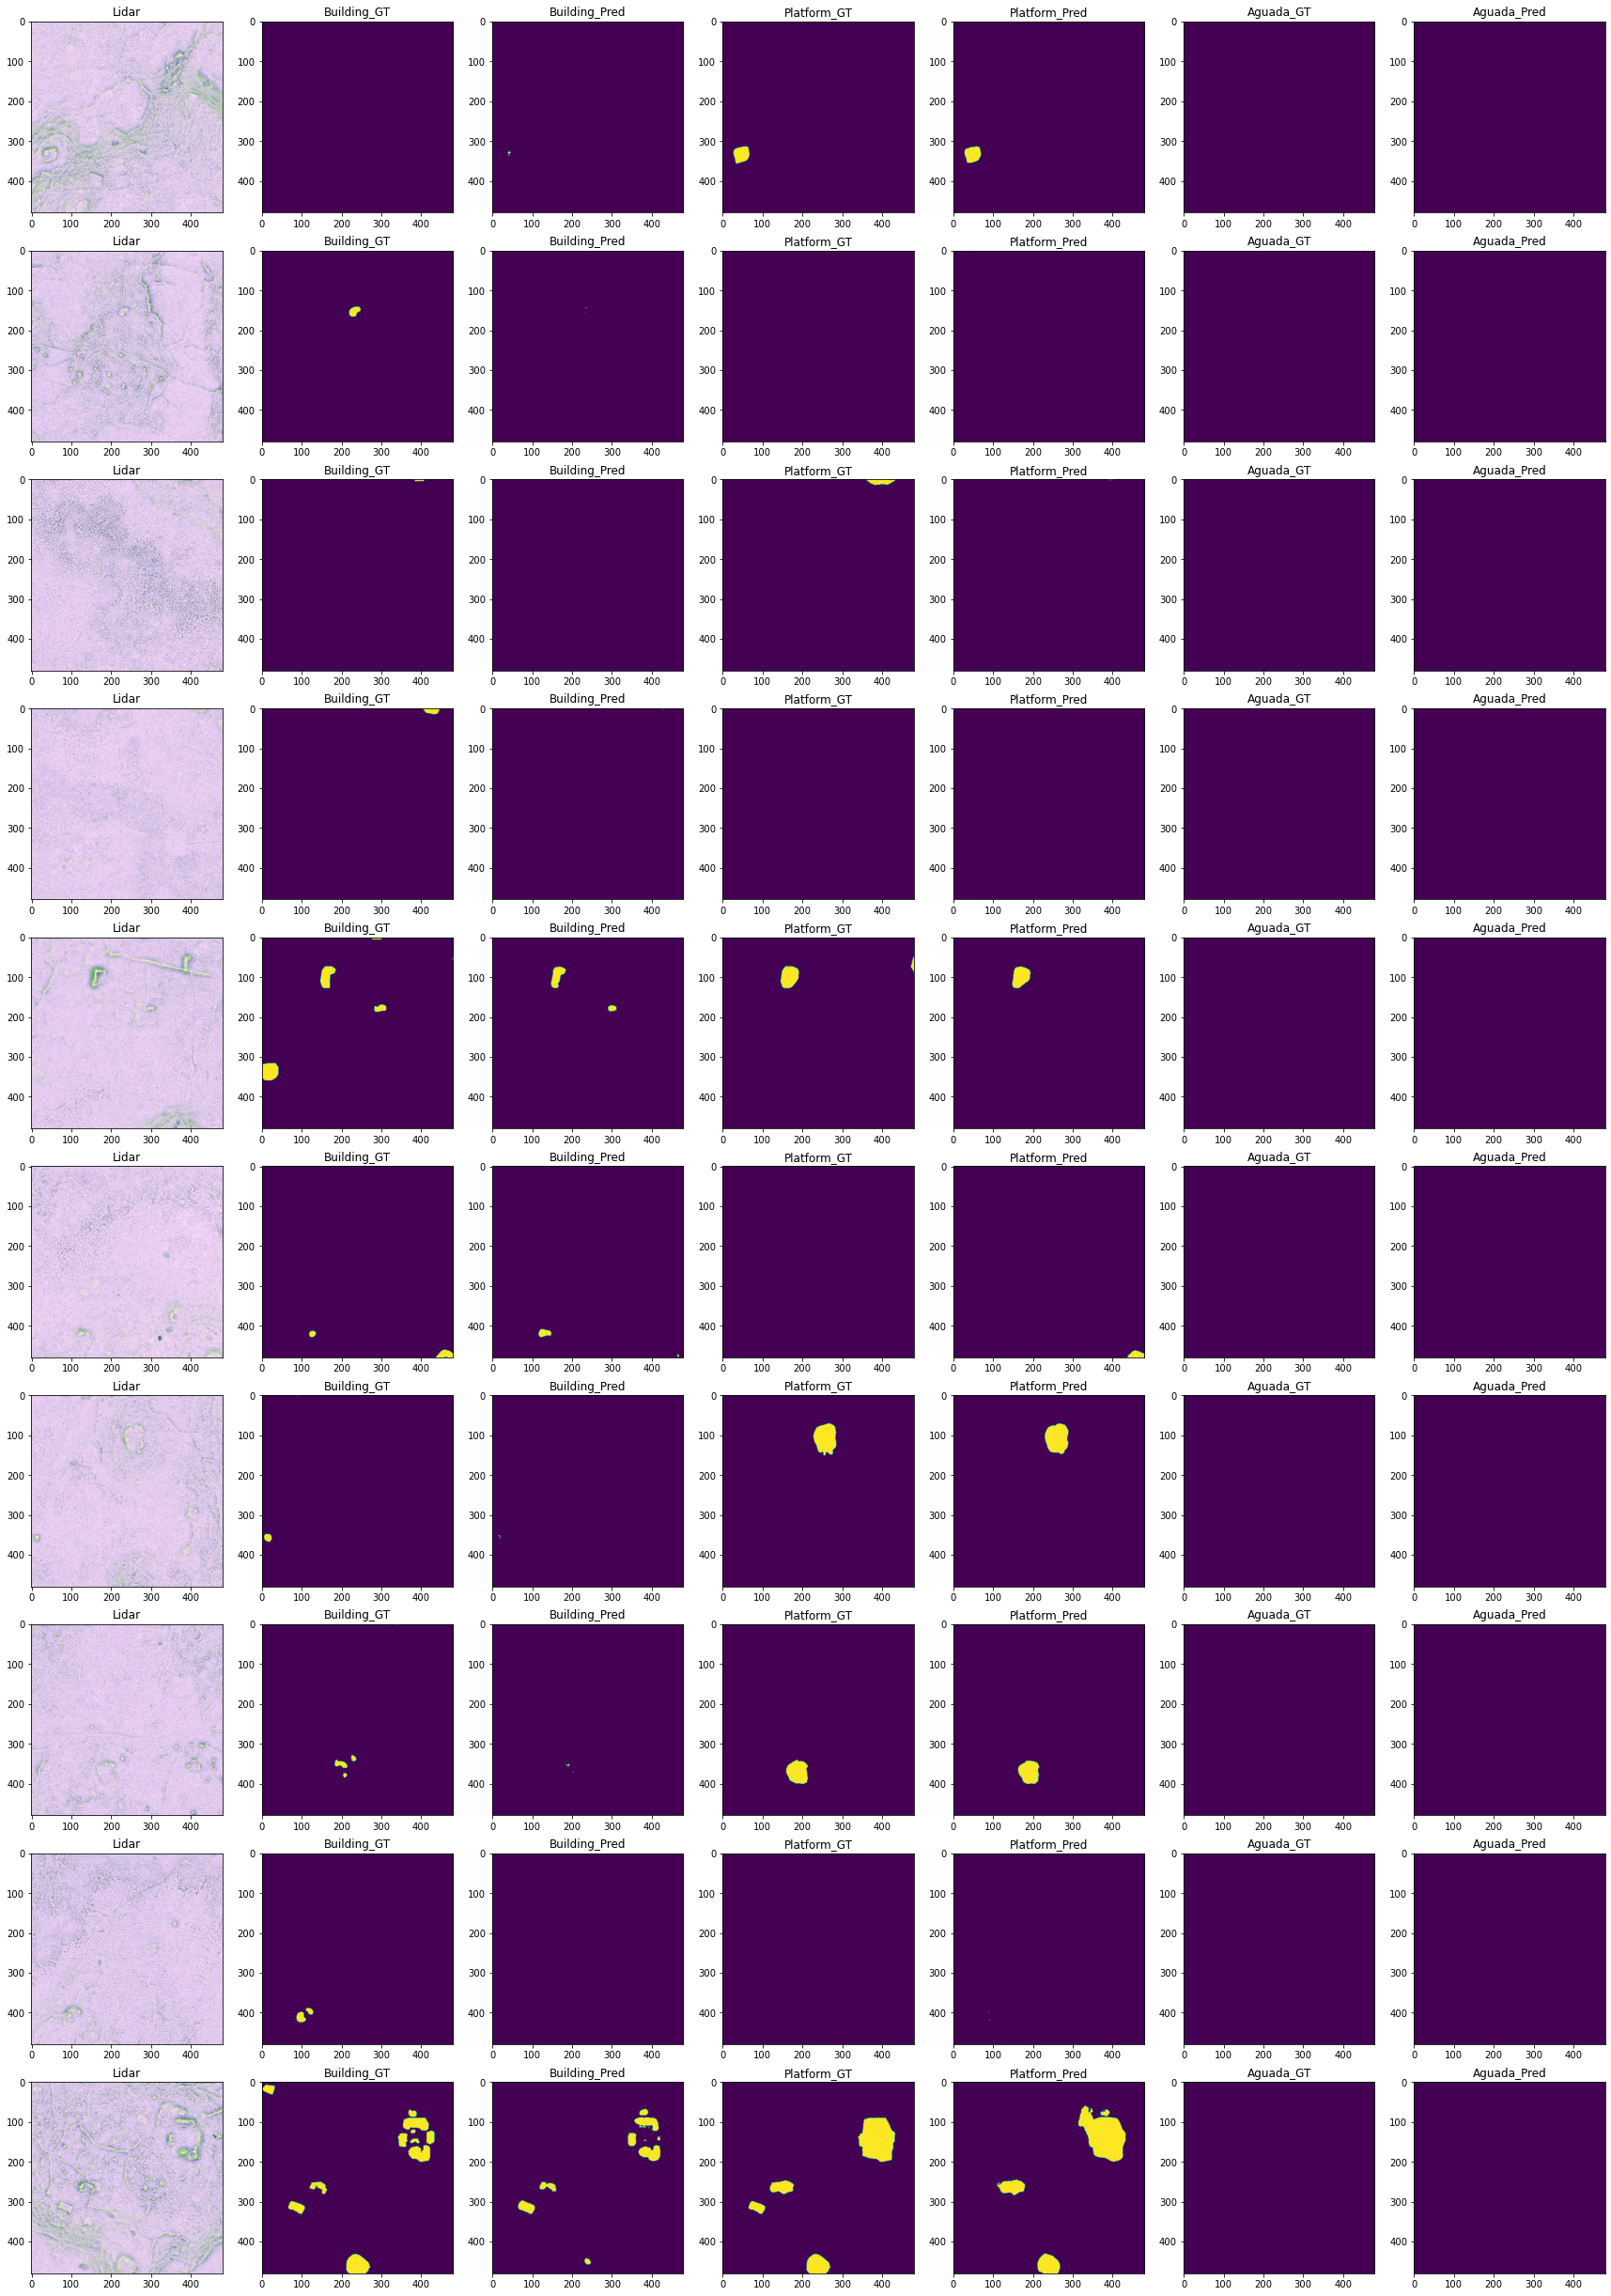

In [20]:
rows = len(tiles)
cols = 7
f, axarr = plt.subplots(rows,cols ,figsize=(24,24 * rows // cols))
f.tight_layout()
t = 0
sigmoid = torch.nn.Sigmoid()
out_threshold = 0.5

with tqdm(total=len(val_loader), desc='Inference', unit='batch', leave=False) as pbar:
    for batch in val_loader:
        idx = str(batch["idx"][0].item())
        if idx in list(tiles):
            lidar = batch['lidar'].to(device=device, dtype=torch.float32)
            sentinel2 = batch['sentinel2'].to(device=device, dtype=torch.float32)
            mask_building = batch['mask_building'].to(device=device, dtype=torch.float32)
            mask_platform = batch['mask_platform'].to(device=device, dtype=torch.float32)
            mask_aguada = batch['mask_aguada'].to(device=device, dtype=torch.float32)

            with torch.no_grad():
                masks_pred = net(lidar, sentinel2)

            masks = sigmoid(masks_pred) > out_threshold 

            for i in range(len(batch['idx'])):
                axarr[t, 0].set_title(f'Lidar')
                axarr[t, 0].imshow(batch['lidar'][i].numpy().transpose(1,2,0))
                axarr[t, 0].set_title(f'Sentinel2')
                axarr[t, 0].imshow(batch['sentinel2'][i][:2].numpy().transpose(1,2,0))
                axarr[t, 1].set_title(f'Building_GT')
                axarr[t, 1].imshow(np.moveaxis(mask_building[i].cpu().numpy().astype(np.uint8),0,-1))
                axarr[t, 2].set_title(f'Building_Pred')
                axarr[t, 2].imshow(np.moveaxis(masks[i, [0]].cpu().numpy().astype(np.uint8),0,-1))
                axarr[t, 3].set_title(f'Platform_GT')
                axarr[t, 3].imshow(np.moveaxis(mask_platform[i].cpu().numpy().astype(np.uint8),0,-1))
                axarr[t, 4].set_title(f'Platform_Pred')
                axarr[t, 4].imshow(np.moveaxis(masks[i, [1]].cpu().numpy().astype(np.uint8),0,-1))
                axarr[t, 5].set_title(f'Aguada_GT')
                axarr[t, 5].imshow(np.moveaxis(mask_aguada[i].cpu().numpy().astype(np.uint8),0,-1))
                axarr[t, 6].set_title(f'Aguada_Pred')
                axarr[t, 6].imshow(np.moveaxis(masks[i, [2]].cpu().numpy().astype(np.uint8),0,-1))
                t += 1

        pbar.update()